In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
# Assign the station class to a variable called `Station`
Station = Base.classes.station

# Assign the measurement class to a variable called `Measurement`
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
start_date = '2017-08-01'
end_date   = '2017-08-07'

temperature_stat = calc_temps(start_date, end_date)
print(f"Temperature stat from {start_date} to {end_date}: {temperature_stat}")

# Save the min, ave and max data
temp_min = temperature_stat[0][0]
temp_ave = temperature_stat[0][1]
temp_max = temperature_stat[0][2]

Temperature stat from 2017-08-01 to 2017-08-07: [(72.0, 79.25, 83.0)]


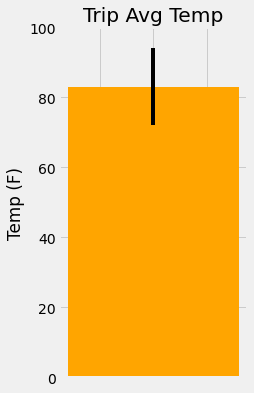

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x_axis = temp_min
y_axis = temp_max
error  = temp_max -  temp_min

plt.figure(figsize=(3,6))

plt.bar(x_axis,y_axis,yerr=error,color="orange")

plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.ylim(0,100)

plt.tick_params(axis='x',labelbottom=False) 
plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates 
# using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, 
# latitude, longitude, and elevation

start_date = '2017-08-01'
end_date   = '2017-08-07'

sel = [ Measurement.station \
      , Station.name \
      , Station.latitude \
      , Station.longitude \
      , Station.elevation \
      , func.sum(Measurement.prcp)]
query_result_daily_rainfall_ave = session.query(*sel).\
                           filter(Measurement.station == Station.station). \
                           filter(Measurement.date >= '2016-08-01'). \
                           filter(Measurement.date <= '2016-08-07').\
                         group_by(Measurement.station).\
                         order_by(func.sum(Measurement.prcp).desc()).all()
query_result_daily_rainfall_ave

daily_rainfall_ave_df = pd.DataFrame ( query_result_daily_rainfall_ave
                                     , columns = [ "Station" 
                                                 , "Station Name" 
                                                 , "Latitude" 
                                                 , "Longitude"  
                                                 , "Elevation" 
                                                 , "Sum prcp"]
                                     )
daily_rainfall_ave_df

,Station,Station Name,Latitude,Longitude,Elevation,Sum prcp
0,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,6.02
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,4.65
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,3.59
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,1.30
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.03
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.57
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.18


### Daily Temperature Normals

In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [14]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date   = '2017-08-07'

# Use the start and end date to create a range of dates
date_ranges = pd.date_range(start_date, end_date)

# Loop throught the list of dates and calculate the daily temperature normals
trip_dates = []
normals = []

for date in date_ranges:
    
    # Save the yyyy-mm-dd as a string
    trip_dates.append(dt.datetime.strftime(date, '%Y-%m-%d'))
    
    # Strip off the year and save strings in the format %m-%d
    date_mm_dd = dt.datetime.strftime(date, '%m-%d')

    # Use the `daily_normals` function to calculate the normals for each date string 
    normal = daily_normals(date_mm_dd)
    
    # Append the results to a list called `normals`.
    normals.append(list(np.ravel(normal)))
    
normals

[[67.0, 75.54, 83.0],
 [68.0, 75.60377358490567, 84.0],
 [70.0, 76.61111111111111, 85.0],
 [69.0, 76.71153846153847, 84.0],
 [69.0, 76.14814814814815, 82.0],
 [67.0, 76.25, 83.0],
 [71.0, 77.15686274509804, 83.0]]

In [15]:
# Load the previous query results into a Pandas DataFrame and 
# add the `trip_dates` range as the `date` index
daily_temp_normals_df = pd.DataFrame ( normals
                                     , columns=["tmin", "tmax", "tavg"]
                                     , index = trip_dates)
                                    

daily_temp_normals_df

,tmin,tmax,tavg
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


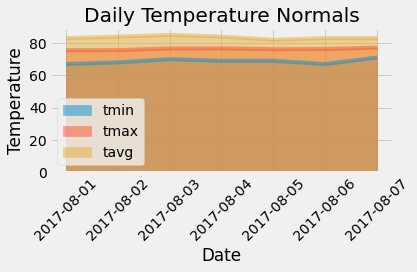

In [16]:
# Plot the daily normals as an area plot with `stacked=False`

daily_temp_normals_df.plot.area(stacked=False)
#
plt.title("Daily Temperature Normals")
plt.xlabel("Date")
plt.ylabel("Temperature")

plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

## Close Session

In [17]:
session.close()